# Analysis of global results

In [147]:
from evaluation_utils import read_global_results, unpivot_baseline_model, unpivot_ssl_model, read_multiple_global_results
from constants import MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, AUXILIARY_ALL,\
    CONTRAST_ALL, HYBRID_ALL, GENERATION_ALL, BASELINES, model_abbreviations, FONT
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joypy
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

%matplotlib.inline


plt.rcParams["font.family"] = FONT

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
# Mode 1 and 2/3 raw
data = read_multiple_global_results(experiments=[
    ('Mode 1', MODE_1_PROCESSED_DIR),
    ('Mode 2/3', MODE_2_3_PROCESSED_DIR)
])

# SSL results
df_ssl = unpivot_ssl_model(df=data, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_baseline_model(df=data, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating
1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


# 

In [25]:
all_models_df = all_models_df.astype({
    'Model': 'category',
    'Experiment': 'category'
})

# Overall model results in each mode

In [3]:
all_models_cols = [TEST_METRIC, 'Graph_ID', 'Experiment']
all_models_df = pd.concat([
    df_ssl.loc[:, all_models_cols + ['SSL_model']].rename(columns={ 'SSL_model': 'Model' }),
    df_baseline.loc[:, all_models_cols + ['Baseline_model']].rename(columns={ 'Baseline_model': 'Model' })
], ignore_index=True)

mode_1_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 1']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 1 rank'})
    .astype({ 'Mode 1 rank': int })
)
mode_2_3_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 2/3']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 2/3 rank'})
    .astype({ 'Mode 2/3 rank': int })
)
all_models_df = (
    all_models_df
    .pipe(pd.merge, right=mode_1_rankings, on='Model')
    .pipe(pd.merge, right=mode_2_3_rankings, on='Model')
)

all_models_df = all_models_df.astype({
    'Model': 'category',
    'Experiment': 'category'
})

In [157]:
all_models_df

,test_rocauc_ovr,Graph_ID,Experiment,Model,Mode 1 rank,Mode 2/3 rank
0,0.949540,0,Mode 1,AttributeMask,15,16
1,0.984346,1,Mode 1,AttributeMask,15,16
2,0.775972,2,Mode 1,AttributeMask,15,16
3,0.763285,3,Mode 1,AttributeMask,15,16
4,0.978847,4,Mode 1,AttributeMask,15,16
...,...,...,...,...,...,...
20780641,0.819011,119424,Mode 2/3,GIN,22,24
20780642,0.898181,119425,Mode 2/3,GIN,22,24
20780643,0.942738,119426,Mode 2/3,GIN,22,24
20780644,0.684476,119427,Mode 2/3,GIN,22,24


In [61]:
def plot_histogram(model_data, model,bins, fig, ax):
    mode1_data = model_data[model_data['Experiment'] == 'Mode 1']

    # # Filter data for Mode 2/3
    mode2_3_data = model_data[model_data['Experiment'] == 'Mode 2/3']

    # Calculate histogram data for Mode 1 and Mode 2/3
    mode1_hist, _ = np.histogram(mode1_data['test_rocauc_ovr'], bins=bins, density=True)
    mode2_3_hist, _ = np.histogram(mode2_3_data['test_rocauc_ovr'], bins=bins, density=True)
    bar_args = { 'width': np.diff(bins), 'align': 'edge', 'alpha': 0.7, 'edgecolor': 'black', 'x': bins[:-1], 'linewidth': 1/2 }

    ax.bar(height=mode1_hist, label='Mode 1', color='darkkhaki', **bar_args)
    ax.bar(height=-mode2_3_hist, label='Mode 2/3', color='teal', **bar_args)

    # Set y-axis label as model name
    ylabel = ax.set_ylabel(model)
    ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right') # Set y-label as model and display horizontally
    ylabel.set_position((-.1, 0.5))  # Move the label to the left


    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.add_subplot(ax)

Text(0.5, 0, 'ROC-AUC')

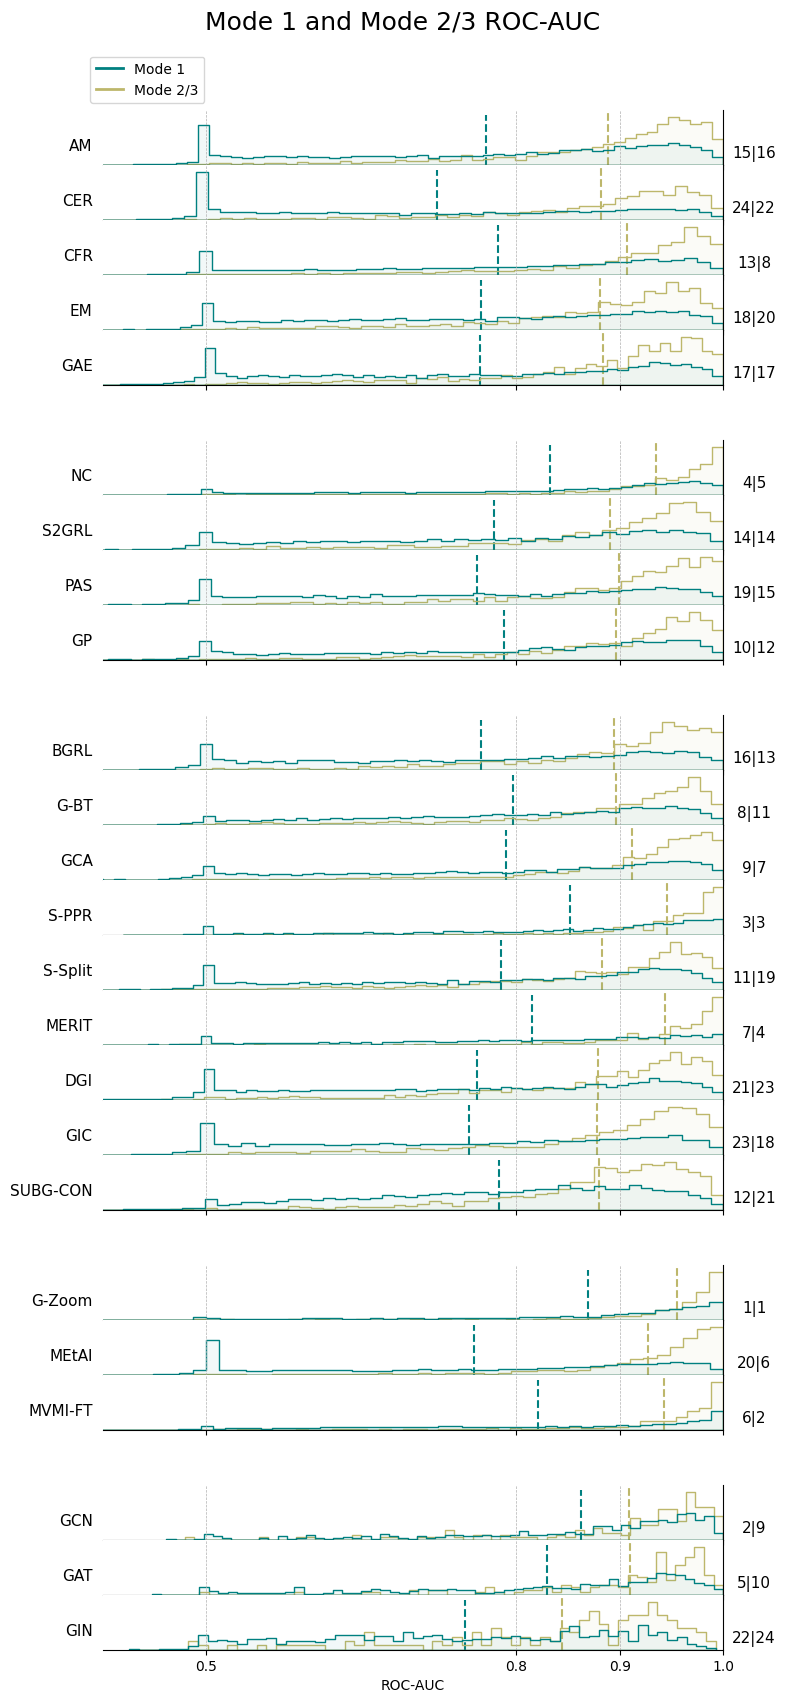

In [213]:
df = all_models_df.sample(150_000)
color_palette = { 'Mode 1': 'darkkhaki', 'Mode 2/3': 'teal' }

models_with_positions = GENERATION_ALL + AUXILIARY_ALL + CONTRAST_ALL + HYBRID_ALL + BASELINES
bins = np.linspace(0.45, 1.0, num=80)
n_rows = len(models_with_positions) + 4

fig = plt.figure(figsize=(8, 20))
outer = gridspec.GridSpec(nrows=n_rows, ncols=1, hspace=0.002)
color_map = { 'Mode 1': 'teal', 'Mode 2/3': 'darkkhaki' }

legend_elements = [
    Line2D([0], [0], color=color_map['Mode 1'], lw=2, label='Mode 1'),
    Line2D([0], [0], color=color_map['Mode 2/3'], lw=2, label='Mode 2/3')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.91))
fig.suptitle('Mode 1 and Mode 2/3 ROC-AUC', fontsize=18, y=0.93)


cur_idx = -1
axes = []
for models_in_category in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, BASELINES]:
    cur_idx += 1
    for model_idx, model in enumerate(models_in_category):
        ax = plt.Subplot(fig, outer[cur_idx])
        axes += [ax]
        model_data = df[df['Model'] == model]
        sns.histplot(model_data, x=TEST_METRIC, hue='Experiment', 
                     stat='percent', common_norm=False, 
                     element='step', fill=True, 
                     alpha=0.05, bins=60,
                     palette=color_map,
                     ax=ax)
        
        means = model_data.groupby('Experiment')[TEST_METRIC].mean()
        maxs = model_data.groupby('Experiment')[TEST_METRIC].max()

        ax.plot([means.loc['Mode 1']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 1'], linestyle='--', zorder=0)
        ax.plot([means.loc['Mode 2/3']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 2/3'], linestyle='--', zorder=0)


        ylabel = ax.set_ylabel(model)
        ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right')
        ylabel.set_position((-.1, 0.2))

        # Add rank information
        mode1_rank = model_data.iloc[0]['Mode 1 rank']
        mode23_rank = model_data.iloc[0]['Mode 2/3 rank']
        rank_text = f"{mode1_rank}|{mode23_rank}"
        ax.annotate(rank_text, xy=(1.05, 0.2), xycoords="axes fraction", fontsize=11, ha='center', va='center')


        ax.get_legend().remove()
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
        ax.set_xlim([0.4, 1.0])
        axes[-1].set_xticks([0.5, 0.8, 0.9, 1])
        cur_idx += 1

        if cur_idx < n_rows:
            ax.set_xlabel('')
            ax.set_xticklabels([])

        fig.add_subplot(ax)


axes[-1].set_xlabel('ROC-AUC')
# axes[0].annotate('Mode 1 rank | Mode 2/3 rank', xy=(1.05, 0.2), xytext=(1.02, 1.8), ha='left', 
#                  va='center', fontsize=11, arrowprops=dict(facecolor='black', shrink=0.05), clip_on=False)
# axes[0].annotate('Mode 1 rank | Mode 2/3 rank', xy=(1.07, 1.9), xycoords="axes fraction", fontsize=13, ha='center', va='center')


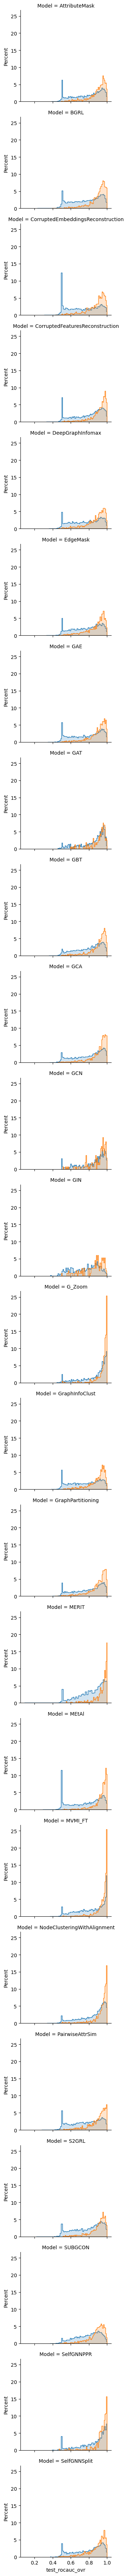

In [73]:
sns.FacetGrid(data=df, row='Model', hue='Experiment', height=3, aspect=1.1)\
    .map(sns.histplot, TEST_METRIC, stat='percent', common_norm=False, element='step', fill=True, alpha=0.2, bins=60)


<Figure size 1200x600 with 0 Axes>

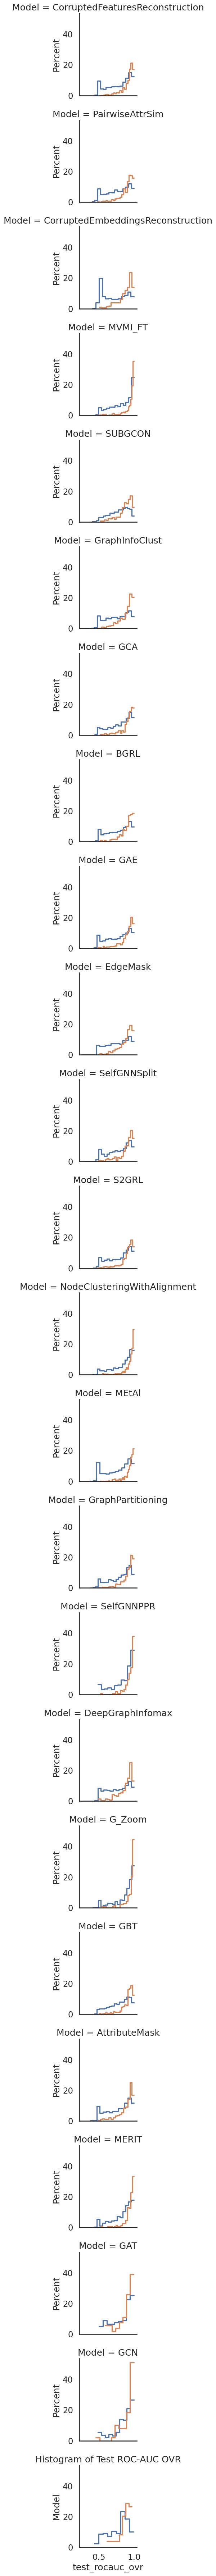

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df'
data = all_models_df

plt.figure(figsize=(12, 6))
# sns.histplot(data=data.sample(50_000), x="test_rocauc_ovr", hue="Experiment", kde=True, element="step", fill=False)

sns.FacetGrid(data.sample(50_000), row='Model', hue='Experiment').map(sns.histplot, TEST_METRIC, stat='percent', element='step', common_norm=False, fill=False)

plt.xlabel("test_rocauc_ovr")
plt.ylabel("Model")
plt.title("Histogram of Test ROC-AUC OVR")

plt.show()

KeyboardInterrupt: 

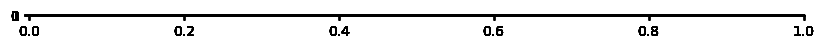

In [55]:
# Merge the model lists
ordered_models = BASELINES + GENERATION_ALL + AUXILIARY_ALL + CONTRAST_ALL + HYBRID_ALL

def plot_histograms(models, df_all):
    fig, axs = plt.subplots(nrows=len(df_all), ncols=1, figsize=(10, len(models) * 2))
    df_all = df_all[df_all.Model.isin(models)]
    df_grp = df_all.groupby('Model')
    for (ax, model) in zip(axs, models):
        df = df_grp.get_group(model)
        sns.histplot(
            data=df.sample(50_000),
            x=TEST_METRIC,
            hue='Experiment',
            ax=ax,
            element='step',
            stat='percent',
            fill=False,
            bins=80,
            common_norm=False,
            palette=color_palette
        )
        ax.set_xlabel('')
        ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right') # Set y-label as model and display horizontally
        ylabel.set_position((-.1, 0.5))  # Move the label to the left
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_legend().remove()

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)  # Set the linewidth of the x-axis line

        ax.tick_params(axis='x', rotation=0)
        ax.set_xticks([])
    return fig, axs

plot_histograms(AUXILIARY_ALL, df_all=all_models_df)

# Encoder results

In [9]:
grp = df_ssl.groupby(['SSL_category', 'Training_scheme', 'Encoder', 'Experiment'])
encoder_mean = grp[TEST_METRIC].mean().reset_index()
encoder_std = grp[TEST_METRIC].std().reset_index()

In [70]:
def create_encoder_latex_table(df_ssl_category_means, df_ssl_category_stds):
    for mode in ['Mode 1', 'Mode 2/3']:
        mode_res = []
        print(mode)
        
        for training_Scheme in ['PF', 'URL', 'JL']:
            for encoder in ['GCN', 'GAT', 'GIN']:
                query = lambda df: (df.Training_scheme == training_Scheme) & (df.Encoder == encoder) & (df.Experiment == mode)
                mean = df_ssl_category_means.loc[query(df_ssl_category_means), TEST_METRIC].values
                std = df_ssl_category_stds.loc[query(df_ssl_category_stds), TEST_METRIC].values
                assert (len(mean) == 1) and (len(std) == 1)
                mode_res += [f'${mean[0]:.2f}\pm{std[0]:.2f}$ ']
        print('& '.join(mode_res))

## Auxiliary-property based

In [71]:
encoder_mean[encoder_mean.SSL_category == AUXILIARY_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
0,Auxiliary-property based,JL,GAT,Mode 1,0.793850
1,Auxiliary-property based,JL,GAT,Mode 2/3,0.917287
2,Auxiliary-property based,JL,GCN,Mode 1,0.810560
3,Auxiliary-property based,JL,GCN,Mode 2/3,0.910199
4,Auxiliary-property based,JL,GIN,Mode 1,0.738649
5,Auxiliary-property based,JL,GIN,Mode 2/3,0.880746
6,Auxiliary-property based,PF,GAT,Mode 1,0.825968
7,Auxiliary-property based,PF,GAT,Mode 2/3,0.923939
8,Auxiliary-property based,PF,GCN,Mode 1,0.852304
9,Auxiliary-property based,PF,GCN,Mode 2/3,0.914073


In [72]:
create_encoder_latex_table(encoder_mean[encoder_mean.SSL_category == AUXILIARY_CATEGORY], encoder_std[encoder_std.SSL_category == AUXILIARY_CATEGORY])

Mode 1
$0.85\pm0.14$ & $0.83\pm0.14$ & $0.76\pm0.14$ & $0.81\pm0.14$ & $0.81\pm0.13$ & $0.71\pm0.15$ & $0.81\pm0.16$ & $0.79\pm0.16$ & $0.74\pm0.16$ 
Mode 2/3
$0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.11$ & $0.91\pm0.10$ & $0.91\pm0.10$ & $0.88\pm0.11$ & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.10$ 


## Generation based

In [13]:
encoder_mean[encoder_mean.SSL_category == GENERATION_BASED_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
36,Generation based,JL,GAT,Mode 1,0.749987
37,Generation based,JL,GAT,Mode 2/3,0.907446
38,Generation based,JL,GCN,Mode 1,0.763364
39,Generation based,JL,GCN,Mode 2/3,0.897827
40,Generation based,JL,GIN,Mode 1,0.686522
41,Generation based,JL,GIN,Mode 2/3,0.863221
42,Generation based,PF,GAT,Mode 1,0.822596
43,Generation based,PF,GAT,Mode 2/3,0.913516
44,Generation based,PF,GCN,Mode 1,0.846950
45,Generation based,PF,GCN,Mode 2/3,0.906145


## Contrast based

In [14]:
encoder_mean[encoder_mean.SSL_category == CONTRAST_BASED]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
18,Contrast based,JL,GAT,Mode 1,0.783036
19,Contrast based,JL,GAT,Mode 2/3,0.909829
20,Contrast based,JL,GCN,Mode 1,0.809396
21,Contrast based,JL,GCN,Mode 2/3,0.910629
22,Contrast based,JL,GIN,Mode 1,0.704184
23,Contrast based,JL,GIN,Mode 2/3,0.865129
24,Contrast based,PF,GAT,Mode 1,0.823247
25,Contrast based,PF,GAT,Mode 2/3,0.914419
26,Contrast based,PF,GCN,Mode 1,0.848946
27,Contrast based,PF,GCN,Mode 2/3,0.915207


## Hybrid

In [15]:
encoder_mean[encoder_mean.SSL_category == HYBRID_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
54,Hybrid,JL,GAT,Mode 1,0.776496
55,Hybrid,JL,GAT,Mode 2/3,0.943562
56,Hybrid,JL,GCN,Mode 1,0.798194
57,Hybrid,JL,GCN,Mode 2/3,0.935838
58,Hybrid,JL,GIN,Mode 1,0.728490
59,Hybrid,JL,GIN,Mode 2/3,0.926338
60,Hybrid,PF,GAT,Mode 1,0.862841
61,Hybrid,PF,GAT,Mode 2/3,0.943636
62,Hybrid,PF,GCN,Mode 1,0.885531
63,Hybrid,PF,GCN,Mode 2/3,0.942678


# Increase in performance

,test_rocauc_ovr,pretext_weight,SSL_model,Encoder,Training_scheme,Graph_ID
0,0.949540,None,AttributeMask,GCN,PF,0
1,0.984346,None,AttributeMask,GCN,PF,1
2,0.775972,None,AttributeMask,GCN,PF,4
3,0.763285,None,AttributeMask,GCN,PF,5
4,0.978847,None,AttributeMask,GCN,PF,6
...,...,...,...,...,...,...
16748248,0.953252,1,MVMI_FT,GIN,JL,99995
16748249,0.727067,50,MVMI_FT,GIN,JL,99996
16748250,0.657303,50,MVMI_FT,GIN,JL,99997
16748251,0.863095,10,MVMI_FT,GIN,JL,99998
